In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from collections import Counter
import spacy

In [28]:
dataset_path = r"C:\Users\Shahnoor Alam\Desktop\Jupyter\data.xlsx"
try:
    df = pd.read_excel(dataset_path)
    print("Dataset loaded successfully!")
except Exception as e:
    print("Error loading dataset:", e)
    exit()

df.head(5)

Dataset loaded successfully!


,Event id,Opened date,CAUSAL_VERBATIM,CORRECTION_VERBATIM,CUSTOMER_VERBATIM,BUILD_DATE,BUILD_PLANT_DESC,CAUSAL_CD_DESC,COMPLAINT_CD_DESC,IN_USE_DATE,MAKE,MODEL,MODLYR,PLANT,Trigger,Failure Component,Failure Condition,Additional Context,Fix Component,Fix Condition
0,D-14801,2019-09-17,unable to duplicate the concern at this time r...,"waiting for techline engineering response, att...",Customer reports that radio and screen is inte...,2019-08-14T00:00:00.000Z,Flint,Module/Component-No/Incorrect Communication,Audio/Entertainment/Navigation - Other issues,2019-09-10T00:00:00.000Z,NovaSprint,AeroSpecter,2020,FLT,['No Additional Functionality'],"['Audio Unit', 'Display']","['Controls Irresponsive', 'Black Screen']",['No Additional Context'],"['Radio', 'SPS']","['Replaced', 'Programmed']"
1,D-14869,2020-07-06,upon inspection radio screen was found to be b...,and ground at radio as stated in service info ...,RADIO IS INOPERABLE CHECK AND ADVISE,2019-08-16T00:00:00.000Z,Fort Wayne,Module/Component-Shorted,Audio/Entertainment/Navigation - Other issues,2020-03-26T00:00:00.000Z,NebulaCruiser,StellarGlide,2020,FTW,['No Additional Functionality'],"['Radio', 'Display', 'Radio']","['Inoperative', 'Black Screen', 'No Sound']",['No Additional Context'],"['Radio', 'USB']","['Replaced', 'Programmed']"
2,D-14555,2020-01-09,Scanned found no codes checked for bulletins f...,radio module internal failure,CUSTOMER STATES RADIO SCREEN AND ONSTAR KEEPS ...,2019-08-06T00:00:00.000Z,Flint,Module/Component-Worn/Stripped,Audio/Entertainment/Navigation - Other issues,2019-11-29T00:00:00.000Z,ThunderVolt,HyperFury X,2020,FLT,['No Additional Functionality'],"['Display', 'OnStar', 'Radio Module']","['Inoperative', 'Inoperative', 'Internal Fault']",['No Additional Context'],['Radio'],['Replaced']
3,D-14704,2020-04-14,"PANTALLA SE PONE NEGRA, LO QUE PROVOCA QUE AL ...",DESPUES DE REALIZAR LA INPECCION VISUAL Y OPER...,PANTALLA SE PONE NEGRA,2019-08-12T00:00:00.000Z,Spring Hill - Truck,Module/Component-No/Incorrect Communication,Features/Controls/Displays - Other issues,2019-12-26T00:00:00.000Z,ThunderVolt,HyperFury X,2020,SHT,['When Reversing'],['Display'],['Black Screen'],['While Driving'],"['Radio', 'USB']","['Replaced', 'Programmed']"
4,D-15142,2020-11-23,INSPECTED VEHICLE AND CONFIRMED THAT THE...,SCRANNED FOR CODES NONE FOUND FOUND UPDATE N...,CUSTOMER STATES A MESSAGE OF LOST SATELITE SIG...,2019-08-27T00:00:00.000Z,Fort Wayne,Module/Component-Registers Incorrectly,Audio/Entertainment/Navigation - Other issues,2019-10-31T00:00:00.000Z,ThunderVolt,TurboFlare,2020,FTW,['No Additional Functionality'],['Radio'],['Malfunction'],['No Additional Context'],['Radio'],['Replaced']


In [29]:
# Convert date columns to datetime format
date_columns = ['BUILD_DATE', 'IN_USE_DATE']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce').dt.strftime('%Y-%m-%d')
df.head(3)

,Event id,Opened date,CAUSAL_VERBATIM,CORRECTION_VERBATIM,CUSTOMER_VERBATIM,BUILD_DATE,BUILD_PLANT_DESC,CAUSAL_CD_DESC,COMPLAINT_CD_DESC,IN_USE_DATE,MAKE,MODEL,MODLYR,PLANT,Trigger,Failure Component,Failure Condition,Additional Context,Fix Component,Fix Condition
0,D-14801,2019-09-17,unable to duplicate the concern at this time r...,"waiting for techline engineering response, att...",Customer reports that radio and screen is inte...,2019-08-14,Flint,Module/Component-No/Incorrect Communication,Audio/Entertainment/Navigation - Other issues,2019-09-10,NovaSprint,AeroSpecter,2020,FLT,['No Additional Functionality'],"['Audio Unit', 'Display']","['Controls Irresponsive', 'Black Screen']",['No Additional Context'],"['Radio', 'SPS']","['Replaced', 'Programmed']"
1,D-14869,2020-07-06,upon inspection radio screen was found to be b...,and ground at radio as stated in service info ...,RADIO IS INOPERABLE CHECK AND ADVISE,2019-08-16,Fort Wayne,Module/Component-Shorted,Audio/Entertainment/Navigation - Other issues,2020-03-26,NebulaCruiser,StellarGlide,2020,FTW,['No Additional Functionality'],"['Radio', 'Display', 'Radio']","['Inoperative', 'Black Screen', 'No Sound']",['No Additional Context'],"['Radio', 'USB']","['Replaced', 'Programmed']"
2,D-14555,2020-01-09,Scanned found no codes checked for bulletins f...,radio module internal failure,CUSTOMER STATES RADIO SCREEN AND ONSTAR KEEPS ...,2019-08-06,Flint,Module/Component-Worn/Stripped,Audio/Entertainment/Navigation - Other issues,2019-11-29,ThunderVolt,HyperFury X,2020,FLT,['No Additional Functionality'],"['Display', 'OnStar', 'Radio Module']","['Inoperative', 'Inoperative', 'Internal Fault']",['No Additional Context'],['Radio'],['Replaced']


In [19]:
# Exploratory Data Analysis (EDA)
def basic_eda(df):
    """Performs basic exploratory data analysis"""
    print("Dataset Info:")
    print(df.info())
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nDuplicate Entries:", df.duplicated().sum())
    print("\nDescriptive Statistics:")
    print(df.describe())
    print("\nSample Data:")
    print(df.head())
    

basic_eda(df)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Event id             1000 non-null   object        
 1   Opened date          1000 non-null   datetime64[ns]
 2   CAUSAL_VERBATIM      997 non-null    object        
 3   CORRECTION_VERBATIM  1000 non-null   object        
 4   CUSTOMER_VERBATIM    999 non-null    object        
 5   BUILD_DATE           1000 non-null   object        
 6   BUILD_PLANT_DESC     1000 non-null   object        
 7   CAUSAL_CD_DESC       997 non-null    object        
 8   COMPLAINT_CD_DESC    1000 non-null   object        
 9   IN_USE_DATE          999 non-null    object        
 10  MAKE                 1000 non-null   object        
 11  MODEL                1000 non-null   object        
 12  MODLYR               1000 non-null   int64         
 13  PLANT               

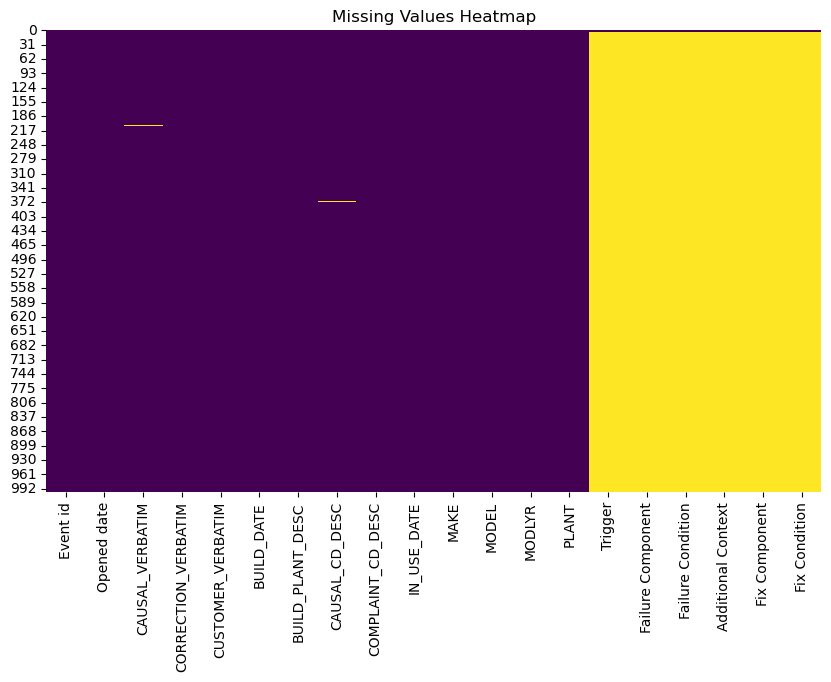

In [20]:
# Visualizing missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

In [21]:
# Data Cleaning
def clean_text(text):
    """Cleans text by removing special characters and stopwords"""
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9 ]', '', text)  # Remove special characters
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text

In [22]:
# Identify free-text columns
text_columns = [col for col in df.columns if df[col].dtype == 'O']
df[text_columns] = df[text_columns].applymap(clean_text)

C:\Users\Shahnoor Alam\AppData\Local\Temp\ipykernel_12568\807367018.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[text_columns] = df[text_columns].applymap(clean_text)


In [23]:
# Text Mining - Extracting Keywords using TF-IDF
vectorizer = TfidfVectorizer(max_features=100)
tfidf_matrix = vectorizer.fit_transform(df[text_columns[0]])  # Modify as needed
keywords = vectorizer.get_feature_names_out()
print("Top extracted keywords:", keywords[:20])

Top extracted keywords: ['d14456' 'd15083' 'd15084' 'd15085' 'd15086' 'd15087' 'd15088' 'd15089'
 'd15090' 'd15091' 'd15092' 'd15093' 'd15094' 'd15095' 'd15096' 'd15097'
 'd15098' 'd15099' 'd15100' 'd15101']


In [24]:
# Categorizing "Type of Issues" using Clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(tfidf_matrix)
df['Cluster'] = kmeans.labels_

C:\Users\Shahnoor Alam\AppData\Local\Temp\ipykernel_12568\4099263286.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Cluster', data=df, palette='viridis')


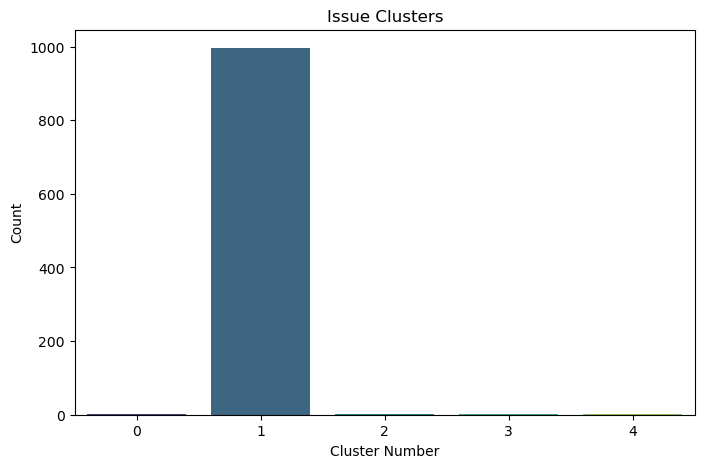

In [25]:
# Visualizing Clusters
plt.figure(figsize=(8, 5))
sns.countplot(x='Cluster', data=df, palette='viridis')
plt.title("Issue Clusters")
plt.xlabel("Cluster Number")
plt.ylabel("Count")
plt.show()

C:\Users\Shahnoor Alam\AppData\Local\Temp\ipykernel_12568\2854547795.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=issue_counts.index, y=issue_counts.values, palette='magma')



Most frequently occurring failure types:
Cluster
1    996
3      1
2      1
4      1
0      1
Name: count, dtype: int64


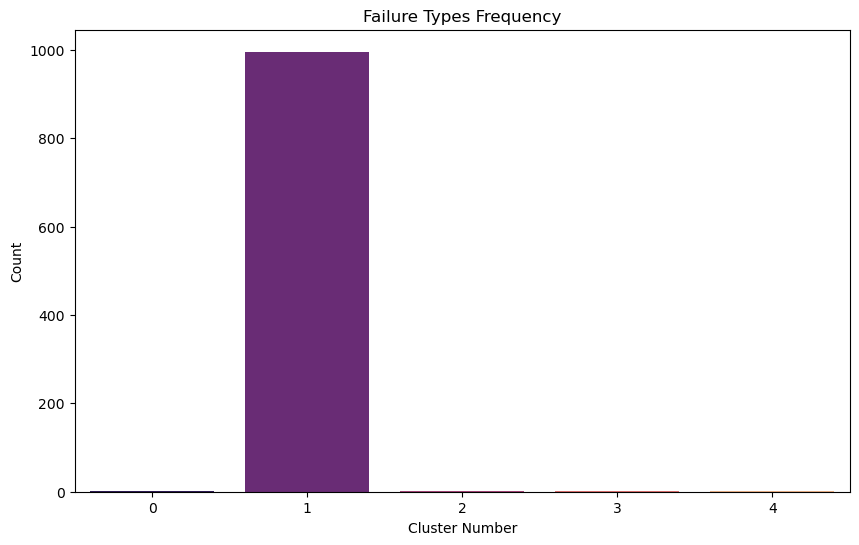

In [26]:
# Identifying Patterns and Trends
def identify_patterns(df):
    """Identifies and summarizes patterns in failure reports"""
    issue_counts = df['Cluster'].value_counts()
    print("\nMost frequently occurring failure types:")
    print(issue_counts)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=issue_counts.index, y=issue_counts.values, palette='magma')
    plt.title("Failure Types Frequency")
    plt.xlabel("Cluster Number")
    plt.ylabel("Count")
    plt.show()

identify_patterns(df)

In [27]:
# Save processed data with extracted tags
df.to_csv("processed_data.csv", index=False)
print("Processed dataset saved as processed_data.csv")

Processed dataset saved as processed_data.csv
